# Natural Language Processing with Deep Learning

__This is exactly the same notebook as in `../week10_textconv/.`__

__Feel free submit the seminar notebook, just make sure you read the assignments at the end.__

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://kaggle2.blob.core.windows.net/competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [3]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
138940,70460543,POS Build Engineer,Role Description: The POS Build Engineer will ...,UK,UK,NaN,permanent,NaN,IT Jobs,"35,000 - 40,000 per year",37500,theitjobboard.co.uk,10.532123
20428,67210480,Shift Leader/Supervisor,My clients who are a medium sized maintenance ...,"EC1, England",Farringdon,NaN,NaN,NaN,Engineering Jobs,42000,42000,britishjobsonthe.net,10.645449
7133,64571226,Experienced Careworkers required for Westminst...,Carewatch Care Services are looking for enthus...,London,London,part_time,NaN,NaN,Healthcare & Nursing Jobs,6.20 to 6.50 per hour,12192,careworx.co.uk,9.408617


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [4]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [5]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [6]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [8]:
target_column

'Log1pSalary'

In [10]:
from collections import Counter
token_counts = Counter()

# Count how many times 
for col in text_columns:
    for text in data[col].values:
        token_counts.update(text.split())

In [11]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('seniorcaddesignengineeraerospace_job', 1)
('discussionbased', 1)
('coloring', 1)
Correct!


Text(0.5,0,'Counts')

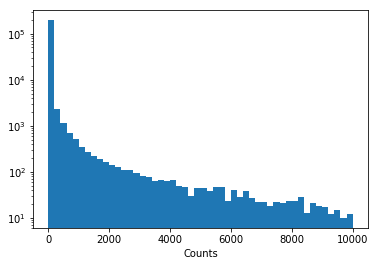

In [12]:
# Let's see how many words are there for each count

_=plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [15]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token, count in token_counts.items() if count >= min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [16]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [18]:
token_to_id = dict(zip(tokens, range(len(tokens))))

In [19]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [20]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [21]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[ 3742 11046 27831     1     1]
 [17091 20167     1     1     1]
 [  412 32000  8534 29865 14116]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [22]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
        sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [23]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [24]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [25]:
generate_batch(data_train, 3, max_len=10)

{'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]], dtype=float32),
 'FullDescription': array([[16547, 20420, 10779, 15894,  6389, 18024,  5469, 26015, 28837,
          5697],
        [32886, 29467,  5469, 27610, 29195, 21589, 21631, 28052, 27610,
         24342],
        [18658, 14109,  5155,  4194, 19622, 16558, 26015,  4041, 31398,
         16064]], dtype=int32),
 'Log1pSalary': array([11.002116, 10.855937,  9.453365], dtype=float32),
 'Title': array([[  412, 34033, 33522,     1,     1,     1,     1,     1],
        [28073, 13663, 22122,  8714, 26122, 22122, 29195, 21589],
        [26122, 13663,   227,     1,     1,     1,     1,     1]],
       dtype=int32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [26]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [234]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()
        self.relu1 = nn.ReLU()
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.pool1(h)
        h = self.relu1(h)
        h = self.dense(h)
        
        return h

In [235]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [237]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()
        self.relu1 = nn.ReLU()
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.pool1(h)
        h = self.relu1(h)
        h = self.dense(h)
        
        return h

In [238]:
desc_encoder = DescriptionEncoder()

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__ Task 2.2__ Build one network ~~to rule them all~~

In [239]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescriptionEncoder(out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        self.cat_encoder = nn.Sequential(
            nn.Linear(n_cat_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.mixer = nn.Sequential(
            nn.Linear(64 * 3, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.cat_encoder(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        output = self.mixer(joint_h)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return output[:, 0]

In [240]:
model = FullNetwork().cuda()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [241]:
# test it on one batch<YOUR CODE>

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"])).cuda()
desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).cuda()
cat_features = Variable(torch.FloatTensor(batch["Categorical"])).cuda()
reference = Variable(torch.FloatTensor(batch[target_column])).cuda()

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [242]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [243]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [244]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [245]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [246]:
for epoch_i in range(num_epochs):
    
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"])).cuda()
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).cuda()
        cat_features = Variable(torch.FloatTensor(batch["Categorical"])).cuda()
        reference = Variable(torch.FloatTensor(batch[target_column])).cuda()

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.cpu().data.numpy()[0]
        train_mae += compute_mae(reference, prediction).cpu().data.numpy()[0]
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    for batch in iterate_minibatches(data_val, batch_size=256, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"]), volatile=True).cuda()
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]), volatile=True).cuda()
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]), volatile=True).cuda()
        reference = Variable(torch.FloatTensor(batch[target_column]), volatile=True).cuda()

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.cpu().data.numpy()[0]
        val_mae += compute_mae(reference, prediction).cpu().data.numpy()[0]
        val_batches += 1
        
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

Training:



	Loss:	12.79959
	MAE:	41362.85396



Validation:



	Loss:	0.65206
	MAE:	7686.11205



Training:



	Loss:	0.56560
	MAE:	7146.22070



Validation:



	Loss:	0.43095
	MAE:	6215.78441



Training:



	Loss:	0.39623
	MAE:	5854.15697



Validation:



	Loss:	0.35781
	MAE:	6241.95608



Training:



	Loss:	0.32533
	MAE:	5307.09841



Validation:



	Loss:	0.29724
	MAE:	4670.20518



Training:



	Loss:	0.28315
	MAE:	4886.69189



Validation:



	Loss:	0.25086
	MAE:	4636.57143



Training:



	Loss:	0.25385
	MAE:	4586.73333



Validation:



	Loss:	0.23073
	MAE:	4474.00065



Training:



	Loss:	0.21834
	MAE:	4222.03961



Validation:



	Loss:	0.20965
	MAE:	4139.33911



Training:



	Loss:	0.21817
	MAE:	4349.69421



Validation:



	Loss:	0.20704
	MAE:	4470.15159



Training:



	Loss:	0.20537
	MAE:	4268.69170



Validation:



	Loss:	0.19793
	MAE:	4414.54864



Training:



	Loss:	0.18411
	MAE:	4021.13896



Validation:



	Loss:	0.17919
	MAE:	3855.29834



Training:



	Loss:	0.17876
	MAE:	4095.24503



Validation:



	Loss:	0.17375
	MAE:	4056.45453



Training:



	Loss:	0.17016
	MAE:	3853.60039



Validation:



	Loss:	0.16483
	MAE:	3827.57500



Training:



	Loss:	0.16819
	MAE:	3909.18564



Validation:



	Loss:	0.18003
	MAE:	4341.03555



Training:



	Loss:	0.15600
	MAE:	3673.28735



Validation:



	Loss:	0.16014
	MAE:	3599.62175



Training:



	Loss:	0.14952
	MAE:	3662.81343



Validation:



	Loss:	0.14476
	MAE:	3571.98773



Training:



	Loss:	0.15075
	MAE:	3663.31964



Validation:



	Loss:	0.15970
	MAE:	3598.86526



Training:



	Loss:	0.15237
	MAE:	3687.46674



Validation:



	Loss:	0.16952
	MAE:	4286.53700



Training:



	Loss:	0.14984
	MAE:	3671.84908



Validation:



	Loss:	0.13516
	MAE:	3412.86502



Training:



	Loss:	0.14804
	MAE:	3742.58510



Validation:



	Loss:	0.13847
	MAE:	3666.10126



Training:



	Loss:	0.14152
	MAE:	3610.54390



Validation:



	Loss:	0.12956
	MAE:	3379.95276



Training:



	Loss:	0.13856
	MAE:	3504.94239



Validation:



	Loss:	0.13011
	MAE:	3506.63686



Training:



	Loss:	0.14025
	MAE:	3598.11397



Validation:



	Loss:	0.14116
	MAE:	3422.32892



Training:



	Loss:	0.14039
	MAE:	3663.29379



Validation:



	Loss:	0.12950
	MAE:	3541.02537



Training:



	Loss:	0.12877
	MAE:	3455.25033



Validation:



	Loss:	0.16296
	MAE:	4346.61655



Training:



	Loss:	0.13371
	MAE:	3570.96533



Validation:



	Loss:	0.12109
	MAE:	3205.05671



Training:



	Loss:	0.11191
	MAE:	3090.90823



Validation:



	Loss:	0.11509
	MAE:	3159.42273



Training:



	Loss:	0.12087
	MAE:	3309.93625



Validation:



	Loss:	0.11183
	MAE:	3133.36178



Training:



	Loss:	0.11723
	MAE:	3235.50248



Validation:



	Loss:	0.14209
	MAE:	3454.07753



Training:



	Loss:	0.11469
	MAE:	3236.92619



Validation:



	Loss:	0.11409
	MAE:	3153.33373



Training:



	Loss:	0.11605
	MAE:	3236.77504



Validation:



	Loss:	0.10981
	MAE:	3109.40395



Training:



	Loss:	0.11188
	MAE:	3216.35271



Validation:



	Loss:	0.10469
	MAE:	3064.33913



Training:



	Loss:	0.12007
	MAE:	3329.42900



Validation:



	Loss:	0.11196
	MAE:	3098.13126



Training:



	Loss:	0.10565
	MAE:	3143.99575



Validation:



	Loss:	0.10459
	MAE:	3025.82662



Training:



	Loss:	0.10199
	MAE:	3087.78168



Validation:



	Loss:	0.10331
	MAE:	3058.82333



Training:



	Loss:	0.10899
	MAE:	3229.10292



Validation:



	Loss:	0.11830
	MAE:	3176.44279



Training:



	Loss:	0.10488
	MAE:	3091.43232



Validation:



	Loss:	0.11019
	MAE:	3065.10469



Training:



	Loss:	0.10621
	MAE:	3176.04643



Validation:



	Loss:	0.11345
	MAE:	3309.31460



Training:



	Loss:	0.10842
	MAE:	3056.23138



Validation:



	Loss:	0.10327
	MAE:	2992.01633



Training:



	Loss:	0.09663
	MAE:	2963.16857



Validation:



	Loss:	0.10960
	MAE:	3274.89854



Training:



	Loss:	0.10174
	MAE:	3027.09645



Validation:



	Loss:	0.10468
	MAE:	3168.73700



Training:



	Loss:	0.10810
	MAE:	3169.96775



Validation:



	Loss:	0.10096
	MAE:	2970.61754



Training:



	Loss:	0.10119
	MAE:	3064.40254



Validation:



	Loss:	0.09751
	MAE:	2967.21253



Training:



	Loss:	0.10312
	MAE:	3089.76248



Validation:



	Loss:	0.12172
	MAE:	3216.57671



Training:



	Loss:	0.10347
	MAE:	3045.20178



Validation:



	Loss:	0.10188
	MAE:	2980.92737



Training:



	Loss:	0.09995
	MAE:	2949.30256



Validation:



	Loss:	0.10877
	MAE:	3271.47456



Training:



	Loss:	0.10051
	MAE:	3046.23224



Validation:



	Loss:	0.11639
	MAE:	3447.90372



Training:



	Loss:	0.09444
	MAE:	2940.74143



Validation:



	Loss:	0.09462
	MAE:	2866.74444



Training:



	Loss:	0.09678
	MAE:	3030.67939



Validation:



	Loss:	0.11744
	MAE:	3176.87064



Training:



	Loss:	0.10143
	MAE:	3083.62989



Validation:



	Loss:	0.11279
	MAE:	3384.81962



Training:



	Loss:	0.08891
	MAE:	2839.83071



Validation:



	Loss:	0.09548
	MAE:	2891.21221



Training:



	Loss:	0.09459
	MAE:	2954.38320



Validation:



	Loss:	0.10384
	MAE:	3152.97330



Training:



	Loss:	0.11116
	MAE:	3297.92992



Validation:



	Loss:	0.11046
	MAE:	3107.79816



Training:



	Loss:	0.10258
	MAE:	3086.44826



Validation:



	Loss:	0.10338
	MAE:	3177.22174



Training:



	Loss:	0.09879
	MAE:	3090.32272



Validation:



	Loss:	0.09256
	MAE:	2868.77659



Training:



	Loss:	0.10519
	MAE:	3033.49729



Validation:



	Loss:	0.12694
	MAE:	3719.12748



Training:



	Loss:	0.10502
	MAE:	3170.19060



Validation:



	Loss:	0.09827
	MAE:	2925.55638



Training:



	Loss:	0.09924
	MAE:	3041.49708



Validation:



	Loss:	0.11444
	MAE:	3117.99174



Training:



	Loss:	0.10939
	MAE:	3234.06589



Validation:



	Loss:	0.10422
	MAE:	3004.78681



Training:



	Loss:	0.10902
	MAE:	3187.81641



Validation:



	Loss:	0.11002
	MAE:	3348.15861



Training:



	Loss:	0.09694
	MAE:	3055.30627



Validation:



	Loss:	0.10337
	MAE:	2989.59343



Training:



	Loss:	0.09474
	MAE:	2918.40541



Validation:



	Loss:	0.09683
	MAE:	2894.98143



Training:



	Loss:	0.10389
	MAE:	3088.83169



Validation:



	Loss:	0.09815
	MAE:	3065.40425



Training:



	Loss:	0.08808
	MAE:	2881.89848



Validation:



	Loss:	0.09071
	MAE:	2941.02611



Training:



	Loss:	0.09610
	MAE:	3048.09621



Validation:



	Loss:	0.09159
	MAE:	2843.47398



Training:



	Loss:	0.09820
	MAE:	2903.29203



Validation:



	Loss:	0.09508
	MAE:	2889.75545



Training:



	Loss:	0.08876
	MAE:	2865.13771



Validation:



	Loss:	0.08767
	MAE:	2813.33231



Training:



	Loss:	0.08948
	MAE:	2821.87680



Validation:



	Loss:	0.10487
	MAE:	3245.11207



Training:



	Loss:	0.09050
	MAE:	2921.61287



Validation:



	Loss:	0.09869
	MAE:	3072.09947



Training:



	Loss:	0.09764
	MAE:	3061.45021



Validation:



	Loss:	0.10278
	MAE:	2971.22378



Training:



	Loss:	0.09214
	MAE:	2898.14569



Validation:



	Loss:	0.08875
	MAE:	2811.55901



Training:



	Loss:	0.08341
	MAE:	2785.12825



Validation:



	Loss:	0.08753
	MAE:	2824.08878



Training:



	Loss:	0.09513
	MAE:	2932.72995



Validation:



	Loss:	0.08930
	MAE:	2818.39116



Training:



	Loss:	0.08668
	MAE:	2877.04878



Validation:



	Loss:	0.08954
	MAE:	2931.99941



Training:



	Loss:	0.08286
	MAE:	2760.33946



Validation:



	Loss:	0.09498
	MAE:	3034.73432



Training:



	Loss:	0.08936
	MAE:	2901.97318



Validation:



	Loss:	0.08605
	MAE:	2819.53655



Training:



	Loss:	0.09426
	MAE:	2961.60236



Validation:



	Loss:	0.09172
	MAE:	2820.86604



Training:



	Loss:	0.09020
	MAE:	2934.60842



Validation:



	Loss:	0.08981
	MAE:	2925.11965



Training:



	Loss:	0.09148
	MAE:	2942.84934



Validation:



	Loss:	0.12608
	MAE:	3310.67514



Training:



	Loss:	0.08764
	MAE:	2846.36904



Validation:



	Loss:	0.08886
	MAE:	2899.78920



Training:



	Loss:	0.08177
	MAE:	2743.09026



Validation:



	Loss:	0.08237
	MAE:	2734.31926



Training:



	Loss:	0.07996
	MAE:	2725.13777



Validation:



	Loss:	0.09596
	MAE:	2900.70032



Training:



	Loss:	0.09133
	MAE:	2928.37319



Validation:



	Loss:	0.08388
	MAE:	2757.53223



Training:



	Loss:	0.08744
	MAE:	2885.24493



Validation:



	Loss:	0.09437
	MAE:	3056.18337



Training:



	Loss:	0.08761
	MAE:	2851.23590



Validation:



	Loss:	0.12789
	MAE:	3825.95571



Training:



	Loss:	0.09046
	MAE:	2958.53645



Validation:



	Loss:	0.08276
	MAE:	2729.81511



Training:



	Loss:	0.07930
	MAE:	2722.34325



Validation:



	Loss:	0.09669
	MAE:	3089.54569



Training:



	Loss:	0.08994
	MAE:	2916.50407



Validation:



	Loss:	0.08641
	MAE:	2846.11040



Training:



	Loss:	0.08730
	MAE:	2830.60394



Validation:



	Loss:	0.08367
	MAE:	2706.04184



Training:



	Loss:	0.07725
	MAE:	2734.74779



Validation:



	Loss:	0.09377
	MAE:	2836.62934



Training:



	Loss:	0.08931
	MAE:	2810.61534



Validation:



	Loss:	0.08615
	MAE:	2824.73462



Training:



	Loss:	0.08510
	MAE:	2767.66870



Validation:



	Loss:	0.11608
	MAE:	3219.95126



Training:



	Loss:	0.08782
	MAE:	2919.96456



Validation:



	Loss:	0.08331
	MAE:	2785.18635



Training:



	Loss:	0.09018
	MAE:	2811.13564



Validation:



	Loss:	0.08209
	MAE:	2700.92699



Training:



	Loss:	0.08427
	MAE:	2764.20871



Validation:



	Loss:	0.08109
	MAE:	2681.56543



Training:



	Loss:	0.08098
	MAE:	2713.07505



Validation:



	Loss:	0.08149
	MAE:	2675.00029



Training:



	Loss:	0.09103
	MAE:	2898.69119



Validation:



	Loss:	0.07999
	MAE:	2694.38666



Training:



	Loss:	0.08549
	MAE:	2784.85197



Validation:



	Loss:	0.09062
	MAE:	2813.28323



Training:



	Loss:	0.07613
	MAE:	2666.00568



Validation:



	Loss:	0.09327
	MAE:	3061.89349



Training:



	Loss:	0.08840
	MAE:	2876.90026



Validation:



	Loss:	0.07955
	MAE:	2646.70468



Training:



	Loss:	0.08124
	MAE:	2786.71389



Validation:



	Loss:	0.08025
	MAE:	2714.46182





In [247]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

for batch in iterate_minibatches(data_val, shuffle=False):
    title_ix = Variable(torch.LongTensor(batch["Title"]), volatile=True).cuda()
    desc_ix = Variable(torch.LongTensor(batch["FullDescription"]), volatile=True).cuda()
    cat_features = Variable(torch.FloatTensor(batch["Categorical"]), volatile=True).cuda()
    reference = Variable(torch.FloatTensor(batch[target_column]), volatile=True).cuda()

    prediction = model(title_ix, desc_ix, cat_features)
    loss = compute_loss(reference, prediction)

    val_loss += loss.cpu().data.numpy()[0]
    val_mae += compute_mae(reference, prediction).cpu().data.numpy()[0]
    val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:



	Loss:	0.08026
	MAE:	2714.89733





### Task 3.2: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

### A short report

val. MAE
- **2714** - baseline
- **2646** - early stopping  - *[E]*
- **2620** - 1 and 2 kernel sizes in addition to 3 - *[A]*
- 2800 - LR from 1e-3 to 5e-3 (larger variance - stopped earlier)
- 2865 - BatchNorm after Convolution/Pooling layer - *[A]*
- **2330** - batch size 32 -> 128, batches per epoch 100 -> 300, epochs 100 -> 35
- **2293** - concatenate max, average and softmax poolings - *[B]*
- 3100 - pre-trained GloVe embeddings, not trainable - *[C]*
- 2300 - pre-trained GloVe embeddings, trainable - *[C]*
- **2089** - Bi-GRU with MaxPooling in parallel with CNN - *[D]*

plotted learning curves - *[E]*

In [362]:
class GlobalAvgPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.mean(dim=self.dim)
    
class GlobalSoftMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return nn.functional.softmax(x, dim=self.dim).sum(dim=self.dim)

### Glove embeddings

In [441]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), kernel_sizes=(1, 2, 3), embed_size=300, hidden_size1=64, out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, embed_size, padding_idx=PAD_IX)
#         self.emb.weight.data.copy_(torch.from_numpy(embed_mtx))
#         self.emb.weight.requires_grad = False
        
        self.convs = []
        for kernel_size in kernel_sizes:
            self.convs.append(nn.Conv1d(embed_size, hidden_size1, kernel_size=kernel_size, padding=kernel_size // 2).cuda())
#         self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.pool1_0 = GlobalMaxPooling()
        self.pool1_1 = GlobalAvgPooling()
        self.pool1_2 = GlobalSoftMaxPooling()
        self.relu1 = nn.ReLU()
    
        self.rnn1 = nn.GRU(embed_size, hidden_size1,
                           num_layers=1, bias=True, batch_first=True,
                           dropout=0,
                           bidirectional=True)
        self.rnn_pool1 = GlobalMaxPooling()
    
        self.dense = nn.Linear(hidden_size1 * 5, out_size)
#         self.dp1 = nn.Dropout(0.5)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        ht = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        convs1 = []
        for conv in self.convs:
            convs1.append(conv(ht))
        convs1_cat = torch.cat(convs1, dim=2)
        
        pool1_0 = self.pool1_0(convs1_cat)
#         h = pool1_0
        pool1_1 = self.pool1_1(convs1_cat)
        pool1_2 = self.pool1_2(convs1_cat)

        rnn1 = self.rnn1(h)[0]
        rnn1 = torch.transpose(rnn1, 1, 2)
        rnn_pool1 = self.rnn_pool1(rnn1)
        
        h = torch.cat([pool1_0, pool1_1, pool1_2, rnn_pool1], dim=1)
    
        h = self.relu1(h)
        h = self.dense(h)
#         h = self.dp1(h)
        return h


class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), kernel_sizes=(1, 2, 3), embed_size=300, hidden_size1=64, out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, embed_size, padding_idx=PAD_IX)
#         self.emb.weight.data.copy_(torch.from_numpy(embed_mtx))
#         self.emb.weight.requires_grad = False
        
        self.convs = []
        for kernel_size in kernel_sizes:
            self.convs.append(nn.Conv1d(embed_size, hidden_size1, kernel_size=kernel_size, padding=kernel_size // 2).cuda())
#         self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.pool1_0 = GlobalMaxPooling()
        self.pool1_1 = GlobalAvgPooling()
        self.pool1_2 = GlobalSoftMaxPooling()
        self.relu1 = nn.ReLU()
    
        self.rnn1 = nn.GRU(embed_size, hidden_size1,
                           num_layers=1, bias=True, batch_first=True,
                           dropout=0,
                           bidirectional=True)
        self.rnn_pool1 = GlobalMaxPooling()
    
        self.dense = nn.Linear(hidden_size1 * 5, out_size)
#         self.dp1 = nn.Dropout(0.5)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        ht = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        convs1 = []
        for conv in self.convs:
            convs1.append(conv(ht))
        convs1_cat = torch.cat(convs1, dim=2)
        
        pool1_0 = self.pool1_0(convs1_cat)
#         h = pool1_0
        pool1_1 = self.pool1_1(convs1_cat)
        pool1_2 = self.pool1_2(convs1_cat)

        rnn1 = self.rnn1(h)[0]
        rnn1 = torch.transpose(rnn1, 1, 2)
        rnn_pool1 = self.rnn_pool1(rnn1)
        
        h = torch.cat([pool1_0, pool1_1, pool1_2, rnn_pool1], dim=1)
    
        h = self.relu1(h)
        h = self.dense(h)
#         h = self.dp1(h)
        return h

In [442]:
title_encoder = TitleEncoder(out_size=64).cuda()

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title'])).cuda()
dummy_v = title_encoder(dummy_x).cuda()

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


In [443]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(hidden_size1=64, out_size=64)
        self.desc_encoder = DescriptionEncoder(hidden_size1=64, out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        self.cat_encoder = nn.Sequential(
            nn.Linear(n_cat_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.mixer = nn.Sequential(
            nn.Linear(64 * 2 + 64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.cat_encoder(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        output = self.mixer(joint_h)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return output[:, 0]

In [444]:
model = FullNetwork().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
opt = torch.optim.Adam(parameters, lr=1e-3)

In [445]:
# test it on one batch<YOUR CODE>

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"])).cuda()
desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).cuda()
cat_features = Variable(torch.FloatTensor(batch["Categorical"])).cuda()
reference = Variable(torch.FloatTensor(batch[target_column])).cuda()

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [446]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [447]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, parameters, retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

In [448]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

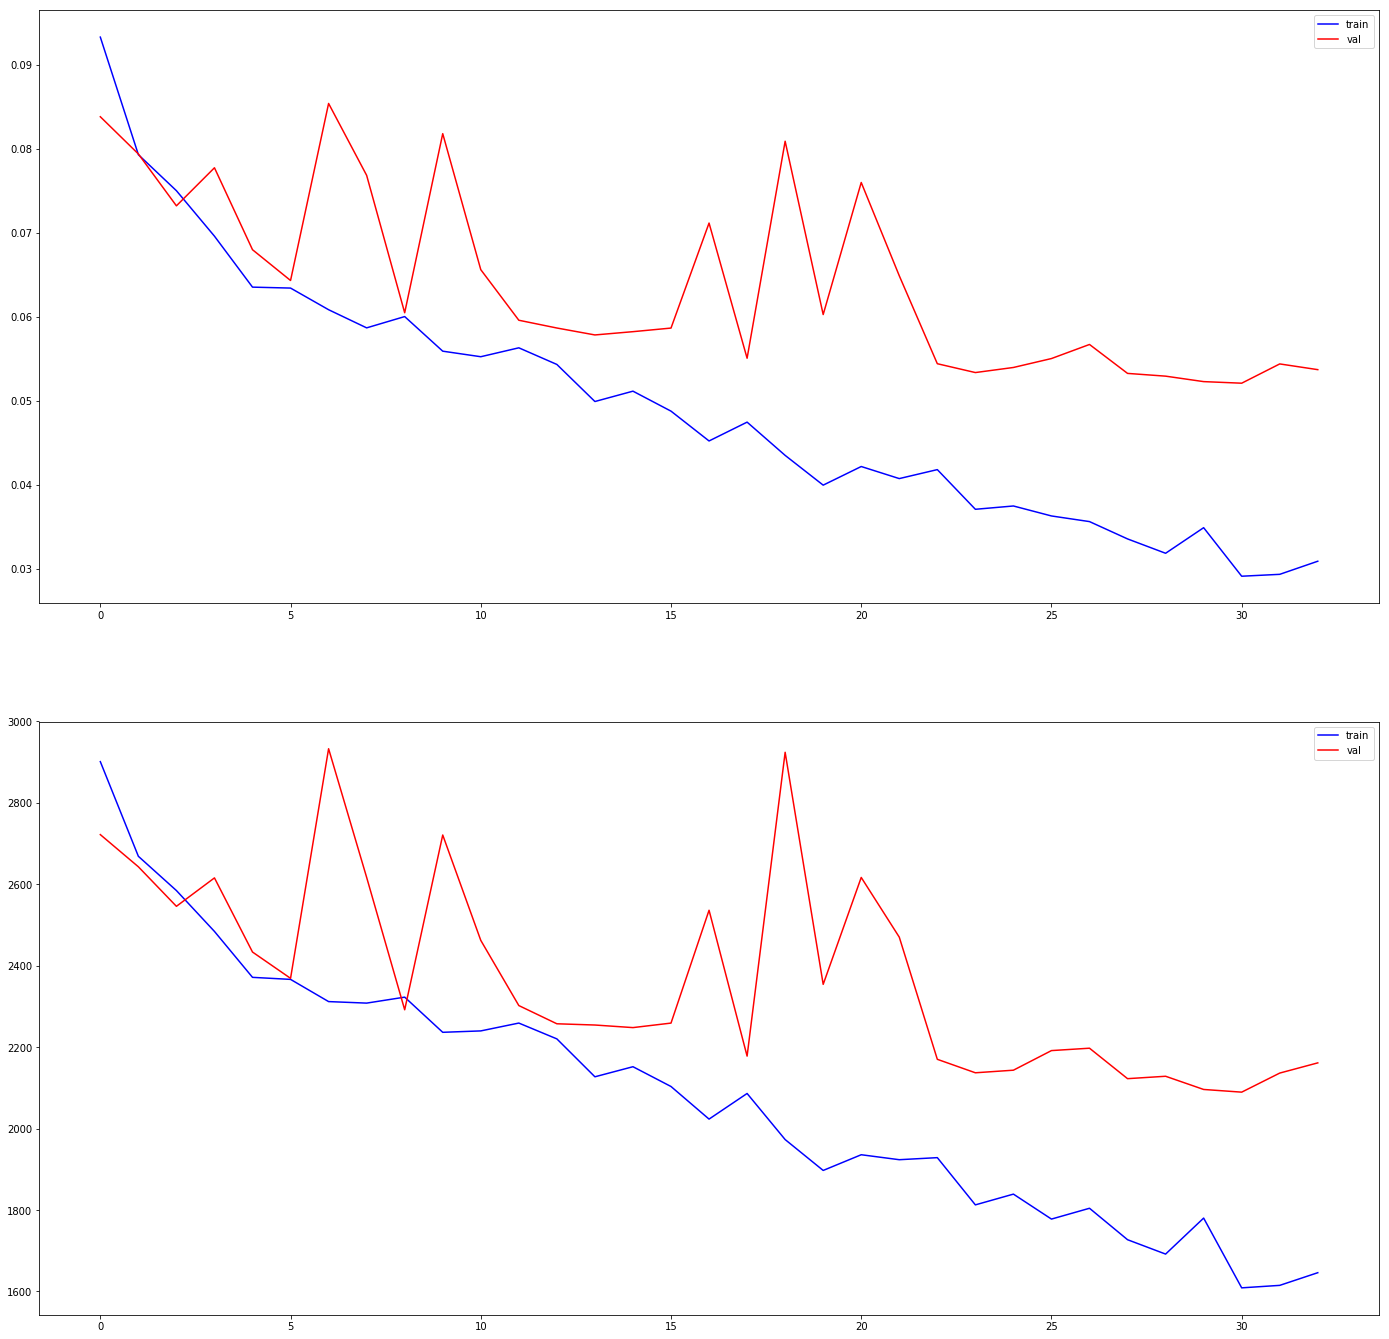

	Loss:	0.05370
	MAE:	2161
	Best MAE:	2089


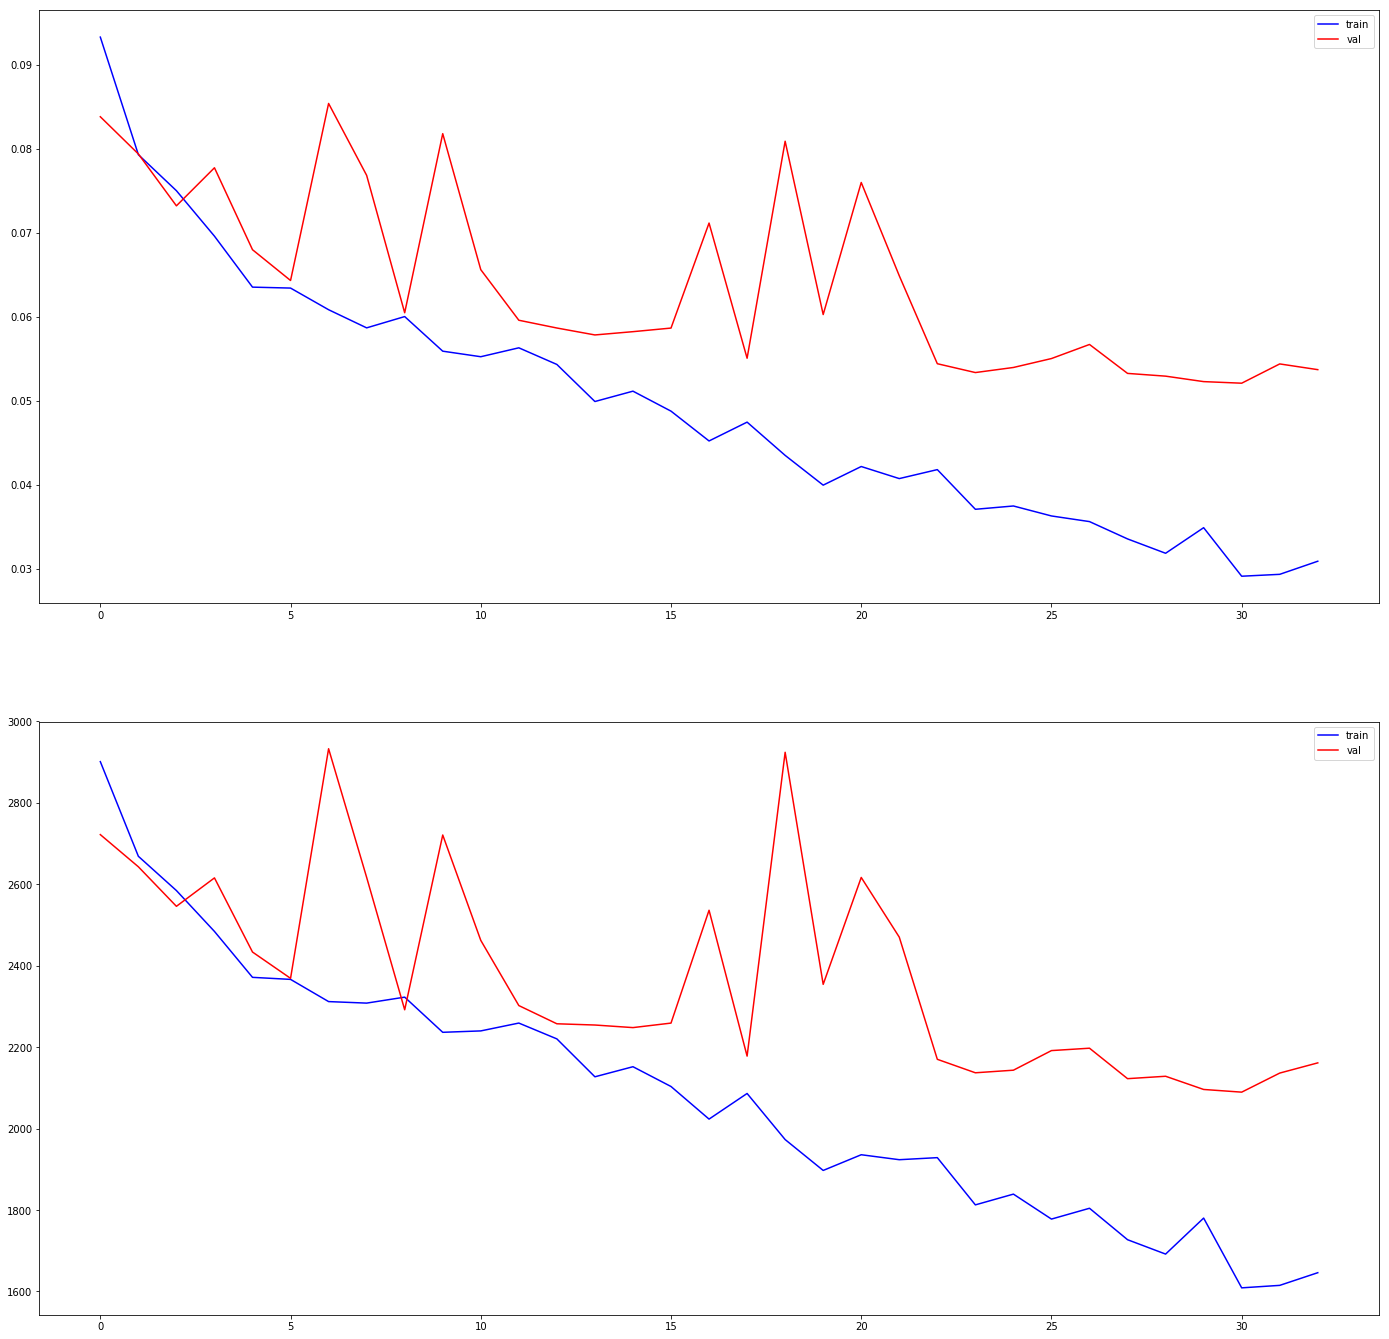

In [449]:
from IPython import display

num_epochs = 35
max_len = 100
batch_size = 128
batches_per_epoch = 300

train_losses = []
train_maes = []
val_losses = []
val_maes = []
show_from_ep = 2

best_val_mae = 1e6
early_stopping_rounds = 10
rounds = 0

for epoch_i in range(num_epochs):

    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, batch_size=batch_size,
                                     max_batches=batches_per_epoch, verbose=False):

        title_ix = Variable(torch.LongTensor(batch["Title"])).cuda()
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).cuda()
        cat_features = Variable(torch.FloatTensor(batch["Categorical"])).cuda()
        reference = Variable(torch.FloatTensor(batch[target_column])).cuda()

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.cpu().data.numpy()[0]
        train_mae += compute_mae(reference, prediction).cpu().data.numpy()[0]
        train_batches += 1
    
    train_losses.append(train_loss / train_batches)
    train_maes.append(train_mae / train_batches)

    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    for batch in iterate_minibatches(data_val, batch_size=batch_size * 2, shuffle=False, verbose=False):
        title_ix = Variable(torch.LongTensor(batch["Title"]), volatile=True).cuda()
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]), volatile=True).cuda()
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]), volatile=True).cuda()
        reference = Variable(torch.FloatTensor(batch[target_column]), volatile=True).cuda()

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.cpu().data.numpy()[0]
        val_mae += compute_mae(reference, prediction).cpu().data.numpy()[0]
        val_batches += 1
        
    val_losses.append(val_loss / val_batches)
    val_maes.append(val_mae / val_batches)
    
    # Early stopping
    if best_val_mae > val_maes[-1]:
        rounds = 0
        best_val_mae = val_maes[-1]
        torch.save(model.state_dict(), "model.pkl")
    else:
        rounds += 1
        if rounds >= early_stopping_rounds:
            print("Stopped earlier at ep. {}".format(epoch_i))
            print("\tLoss:\t%.5f" % val_losses[-1])
            print("\tMAE:\t%.5f" % val_maes[-1])
            break

    plt.clf()
    if epoch_i >= show_from_ep: # don't show the first values of the losses (too big)
        plt.figure(figsize=(24,24))
        plt.subplot(2,1,1)
        plt.plot(train_losses[show_from_ep:], c="blue", label="train")
        plt.plot(val_losses[show_from_ep:], c="red", label="val")
        plt.legend()
        plt.subplot(2,1,2)
        plt.plot(train_maes[show_from_ep:], c="blue", label="train")
        plt.plot(val_maes[show_from_ep:], c="red", label="val")
        plt.legend()
        display.clear_output(wait=True)
        display.display(plt.gcf())
        print("\tLoss:\t%.5f" % val_losses[-1])
        print("\tMAE:\t%d" % int(val_maes[-1]))
        print("\tBest MAE:\t%d" % int(best_val_mae))

In [450]:
print("\tMAE:\t%d" % int(best_val_mae))

	MAE:	2089
